## Time-Series Dataset Generation

### Input

Let $\text{input}[\text{vers}][\text{win},\text{samp},\text{sens}]$ be the array of input data of size:  
$\bigl[\text{numOfVers}\times(\text{numOfWins}\times\text{numOfSamps}\times\text{numOfSens})\bigr]$  

$\text{input}[0][\text{win},\text{samp},\text{sens}]$ is the input data version which the sensors are decoupled  
Sensors are coupled more as $\text{vers}$ increases  

$\text{input}[\text{vers}][\text{win},\text{samp},\text{sens}]=\begin{cases}
\text{setRange}\Bigl(\text{rand}(\text{sens})\Bigr),\\
\quad\text{if samp}=0\text{ and win}=0\\
\text{setRange}\Biggl(\text{rand}(\text{sens})+\text{pullToZero}\Bigl(\text{input}\bigl[
\text{vers}\bigr]\bigl[\text{win}-1,\text{numOfSamps}-1,\text{couple}(\text{vers},\text{sens})\bigr]\Bigr)\Biggr),\\
\quad\text{if samp}=0\text{ and win}>0\\
\text{setRange}\Biggl(\text{rand}(\text{sens})+\text{pullToZero}\Bigl(\text{input}\bigl[
\text{vers}\bigr]\bigl[\text{win},\text{samp}-1,\text{couple}(\text{vers},\text{sens})\bigr]\Bigr)\Biggr),\\
\quad\text{if samp}>0
\end{cases}$

Previous example: [/examples/check_py_env.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/check_py_env.ipynb)  
Next example: [/examples/time_series/cases/1.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/time_series/cases/1.ipynb)

In [1]:
import sys
sys.path.insert(0, '../../') # To be able to reach 'datasets' folder
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = Path.cwd().parent.parent / 'datasets' / 'time_series'
dataset_path.mkdir(parents=True, exist_ok=True)
windows_path = dataset_path / 'windows'
windows_path.mkdir(parents=True, exist_ok=True)
stats_path = dataset_path / 'stats'
stats_path.mkdir(parents=True, exist_ok=True)

In [3]:
# batchSize = (2 ** 0) or ... or (2 ** 8)
# Train: 60%
# Val:   20%
# Test:  20%
class In_Dims:
    numOfVers = 2
    numOfWins = 256 * (6 + 2 + 2) * 2 * 6 # Only change the integer at the end with another integer
    numOfSamps = 2 ** 5
    numOfSens = 3


class In_Sets:
    alpha = 16 # Determines the sensor range
    beta = 80 # As it grows, sensor values can deviate from zero more easily

In [4]:
def setRange(arg):
    """
    Introduces minimum and maximum values to the sensor readings
    """
    if arg > In_Sets.alpha: return In_Sets.alpha
    elif arg < -In_Sets.alpha: return -In_Sets.alpha
    else: return arg


def rand(sens):
    """
    Samples a random value independently from a normal distribution
    """
    temp = (sens - ((In_Dims.numOfSens - 1) / 2)) / In_Dims.numOfSens
    return np.random.normal(0.2 * temp, 2 / (1 + abs(temp)))


def pullToZero(arg):
    """
    Avoids the sample to deviate from being zero-mean too much
    """
    return arg * ((1 + np.cos(min(np.pi, np.pi * abs(arg) / In_Sets.beta))) / 2)


def couple(vers, sens):
    """
    Returns the same sensor for the decoupled data input[0][i,j,k], 
    and mixes sensor numbers for the coupled data input[v][i,j,k] for v>0
    """
    return (sens + round(vers * np.random.normal() / 3)) % In_Dims.numOfSens

In [5]:
input = [np.zeros((In_Dims.numOfWins, In_Dims.numOfSamps, In_Dims.numOfSens), dtype=np.float32) \
    for _ in range(In_Dims.numOfVers)]

for vers in range(In_Dims.numOfVers):
    for win in range(In_Dims.numOfWins):
        for samp in range(In_Dims.numOfSamps):
            for sens in range(In_Dims.numOfSens):
                if samp > 0:
                    input[vers][win, samp, sens] = \
                        setRange(rand(sens) + pullToZero(input[vers][win, samp - 1, couple(vers, sens)]))
                elif win == 0: # samp == 0
                    input[vers][win, samp, sens] = \
                        setRange(rand(sens))
                else: # (samp == 0) and (win > 0)
                    input[vers][win, samp, sens] = \
                        setRange(rand(sens) + pullToZero(input[vers][win - 1, -1, couple(vers, sens)]))

print(type(input), len(input))
print(type(input[0]), input[0].shape)
print(type(input[0][0, 0, 0]))

<class 'list'> 2
<class 'numpy.ndarray'> (30720, 32, 3)
<class 'numpy.float32'>


### Output

Let $\text{output}[\text{within}][\text{inter}][\text{vers}][\text{win}]$ be the array of input data of size:  
$(2\times 2\times\text{numOfVers}\times\text{numOfWins})$  

$\text{output}[1][\text{inter}][\text{vers}][\text{win}]$ is the output data version which depends on within-window relations  
$\text{output}[0][\text{inter}][\text{vers}][\text{win}]$ does not depend on within-window relations  

$\text{output}[\text{within}][\text{1}][\text{vers}][\text{win}]$ is the output data version which depends on inter-window relations  
$\text{output}[\text{within}][\text{0}][\text{vers}][\text{win}]$ does not depend on within-window relations  

$\begin{aligned}
\text{output}[\text{within}][\text{inter}][\text{vers}][\text{win}]
&=\Bigl(\text{baseFn}\bigl(X[\text{vers}][\text{win},\text{numOfSamps}-1,:]\bigr)\\
&+\text{within}\times\text{withinFn}\bigl(X[\text{vers}][\text{win},:,:]\bigr)\\
&+\text{inter}\times\text{interFn}\bigl(X[\text{vers}][\text{win},:,:],X[\text{vers}][\text{win}-1,:,:]\bigr)\Bigr)/(1+\text{within}+\text{inter})
\end{aligned}$

In [6]:
def baseFn(vers, win):
    """
    Depends only on a single sample (no within-window or inter-window dependence)
    """
    return np.float32(np.random.normal(min(input[vers][win, -1, :]), .1))


def withinFn(vers, win):
    """
    Depends on all window (within-window dependence)
    """
    sensor_max_diff = []
    for sens in range(In_Dims.numOfSens):
        sensor_max_diff.append(max(np.diff(input[vers][win, :, sens])))
    
    sensor_min = []
    for sens in range(In_Dims.numOfSens):
        sensor_min.append(min(input[vers][win, :, sens]))

    return max(sensor_max_diff) + min(sensor_min)


def interFn(vers, win):
    """
    Depends on inter-window samples (single sample from the previous window)
    """
    sensor_mean = []
    sensor_mean_prev = []
    for sens in range(In_Dims.numOfSens):
        sensor_mean.append(np.mean(input[vers][win, :, sens]))
        sensor_mean_prev.append(np.mean(input[vers][win - 1, :, sens]))
    
    return max(sensor_mean) - max(sensor_mean_prev)


def relation_str(within, inter):
    """
    Name of output variation
    """
    if (not within) and (not inter): return 'None'
    elif within and (not inter): return 'Within'
    elif (not within) and inter: return 'Inter'
    elif within and inter: return 'Both'

In [7]:
output = [[[np.zeros(In_Dims.numOfWins, dtype=np.float32) \
    for _ in range(In_Dims.numOfVers)] \
        for _ in range(2)] \
            for _ in range(2)]

for within in range(2):
    for inter in range(2):
        for vers in range(In_Dims.numOfVers):
            for win in range(In_Dims.numOfWins):
                output[within][inter][vers][win] = \
                    (baseFn(vers, win) + within * withinFn(vers, win) + inter * interFn(vers, win)) / (1 + within + inter)

print(type(output), len(output))
print(type(output[0]), len(output[0]))
print(type(output[0][0]), len(output[0][0]))
print(type(output[0][0][0]), len(output[0][0][0]))
print(type(output[0][0][0][0]))

<class 'list'> 2
<class 'list'> 2
<class 'list'> 2
<class 'numpy.ndarray'> 30720
<class 'numpy.float32'>


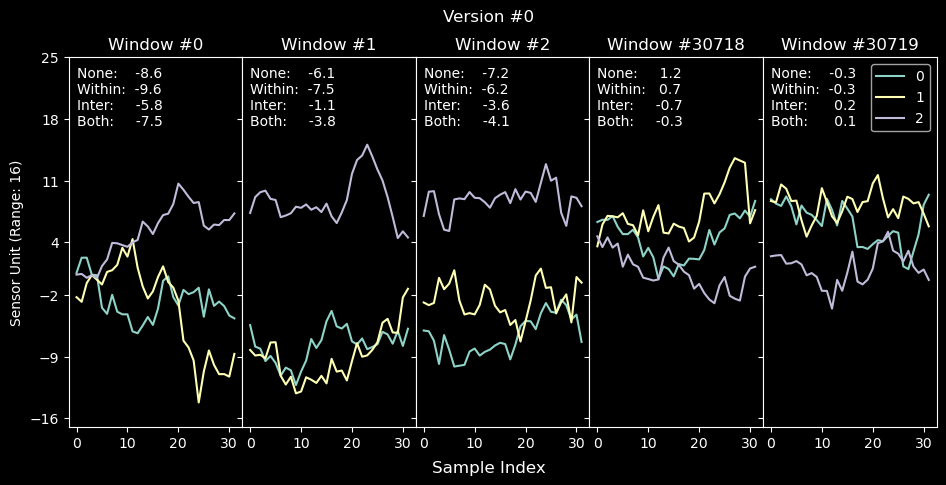

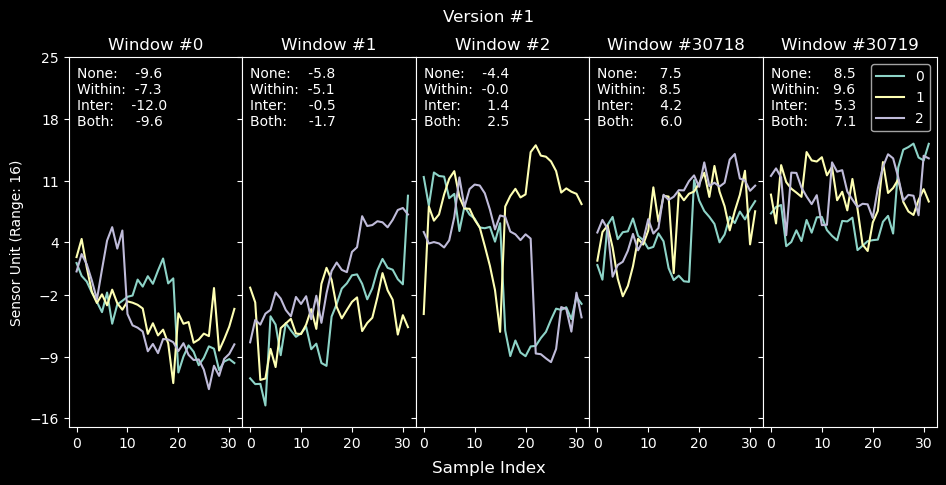

In [8]:
wins = [0, 1, 2, In_Dims.numOfWins - 2, In_Dims.numOfWins -1]

for vers in range(In_Dims.numOfVers):
    plt.style.use('dark_background')
    def_size = plt.rcParams.get('figure.figsize')
    fig, axes = plt.subplots(1, len(wins), sharey=True, figsize=(1.75 * def_size[0], def_size[1]))
    fig.subplots_adjust(wspace=0)
    fig.suptitle(f'Version #{vers}')
    fig.supxlabel('Sample Index')
    axes[0].set_ylabel(f'Sensor Unit (Range: {In_Sets.alpha})')
    plt.ylim(-In_Sets.alpha - 1, In_Sets.alpha + 1)
    plt.yticks(np.round(np.linspace(-In_Sets.alpha, 1.55 * In_Sets.alpha, num=7)))
    for axis_num in range(len(wins)):
        win = wins[axis_num]
        axes[axis_num].plot(input[vers][win, :, :])
        axes[axis_num].set_title(f'Window #{win}')
        axes[axis_num].text(0, 1.5 * In_Sets.alpha, \
            f'{relation_str(0, 0)}:   {output[0][0][vers][win]:5.1f}' + \
            f'\n{relation_str(1, 0)}: {output[1][0][vers][win]:5.1f}' + \
            f'\n{relation_str(0, 1)}:    {output[0][1][vers][win]:5.1f}' + \
            f'\n{relation_str(1, 1)}:    {output[1][1][vers][win]:5.1f}',
            ha='left', va='top')
        
        if axis_num == len(wins) - 1:
            axes[axis_num].legend(range(len(input[vers][0, 0, :])), loc='upper right')
    
    fig_name = windows_path / f'in{vers}.pdf'
    if fig_name.is_file(): fig_name.unlink()
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

In [9]:
modes = ['mean', 'std', 'min', 'max', 'base', 'within', 'inter']

col_names = []
for sens in range(In_Dims.numOfSens):
    for mode in modes:
        col_names.append(f'{mode}{sens}')

col_names.append('out')
wins_to_consider = min(In_Dims.numOfWins, 256) # Not necessary to analyse all
stats = [[[pd.DataFrame(np.float32(0), index=range(wins_to_consider), columns=col_names) \
    for _ in range(In_Dims.numOfVers)] \
        for _ in range(2)] \
            for _ in range(2)]

for within in range(2):
    for inter in range(2):
        for vers in range(2):
            for win in np.arange(1, wins_to_consider):
                for sens in range(In_Dims.numOfSens):
                    for mode in modes:
                        if mode == 'mean':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = np.mean(input[vers][win, :, sens])
                        elif mode == 'std':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = np.std(input[vers][win, :, sens])
                        elif mode == 'min':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = np.min(input[vers][win, :, sens])
                        elif mode == 'max':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = np.max(input[vers][win, :, sens])
                        elif mode == 'base':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = baseFn(vers, win)
                        elif mode == 'within':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = withinFn(vers, win)
                        elif mode == 'inter':
                            stats[within][inter][vers].loc[win, f'{mode}{sens}'] = interFn(vers, win)
                
                stats[within][inter][vers].loc[win, 'out'] = output[within][inter][vers][win]

print(type(stats), len(stats))
print(type(stats[0]), len(stats[0]))
print(type(stats[0][0]), len(stats[0][0]))
print(stats[0][0][0].info())

<class 'list'> 2
<class 'list'> 2
<class 'list'> 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mean0    256 non-null    float32
 1   std0     256 non-null    float32
 2   min0     256 non-null    float32
 3   max0     256 non-null    float32
 4   base0    256 non-null    float32
 5   within0  256 non-null    float32
 6   inter0   256 non-null    float32
 7   mean1    256 non-null    float32
 8   std1     256 non-null    float32
 9   min1     256 non-null    float32
 10  max1     256 non-null    float32
 11  base1    256 non-null    float32
 12  within1  256 non-null    float32
 13  inter1   256 non-null    float32
 14  mean2    256 non-null    float32
 15  std2     256 non-null    float32
 16  min2     256 non-null    float32
 17  max2     256 non-null    float32
 18  base2    256 non-null    float32
 19  within2  256 non-null    float32
 20  int

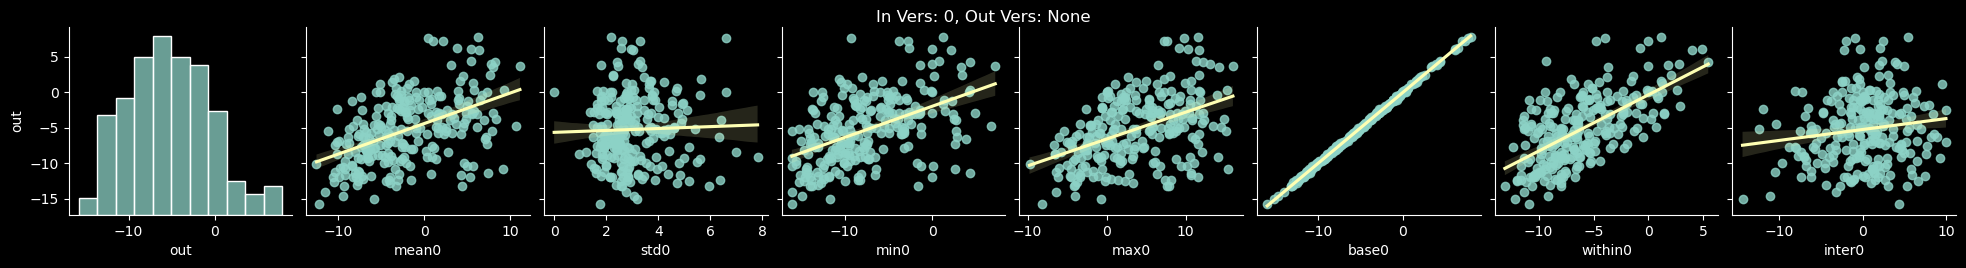

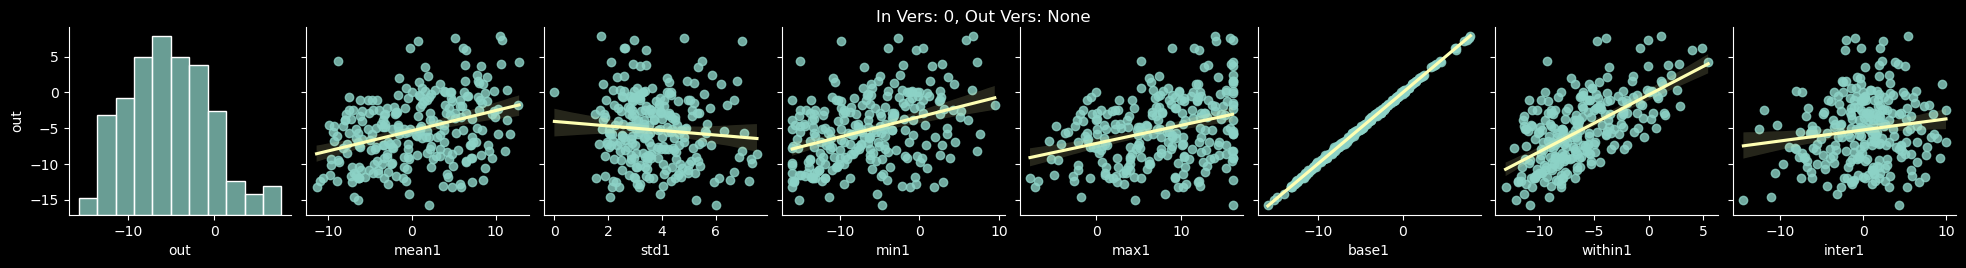

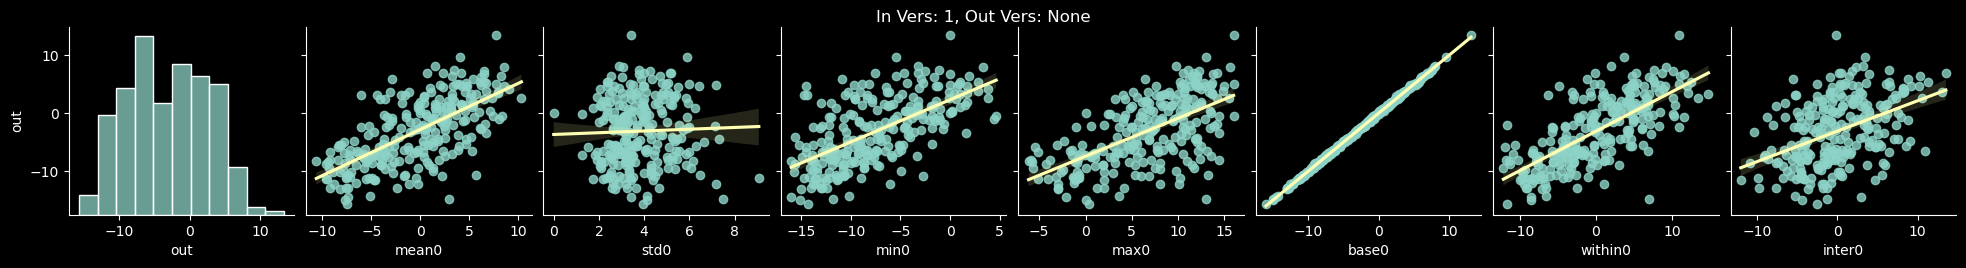

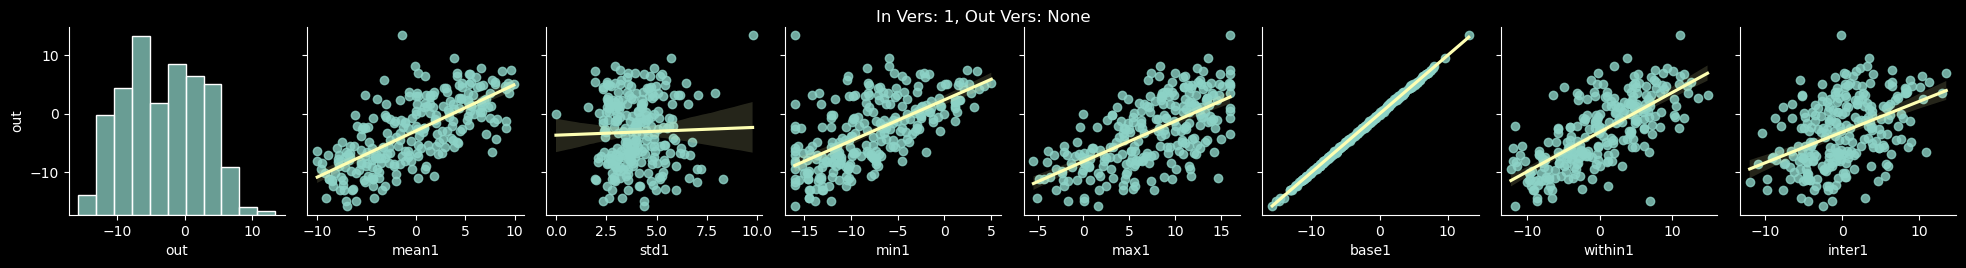

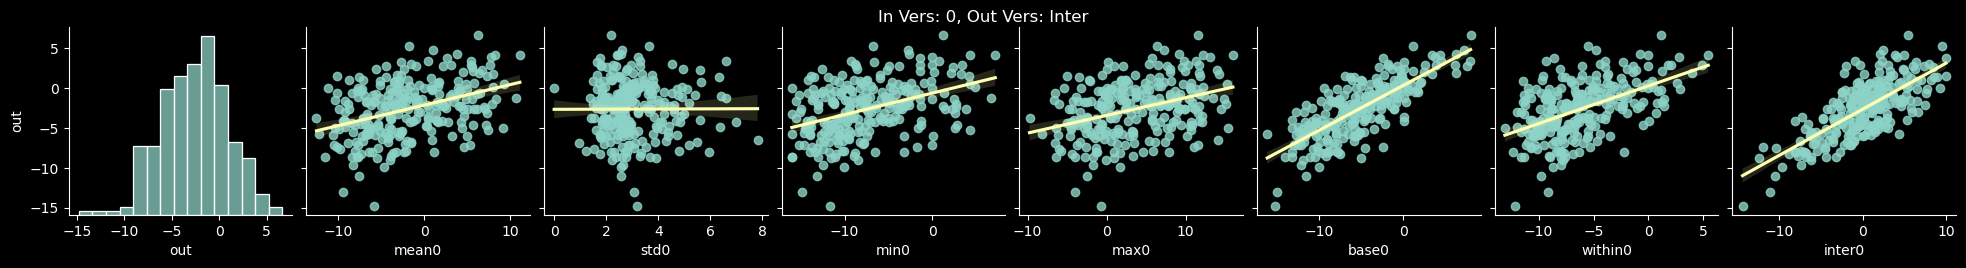

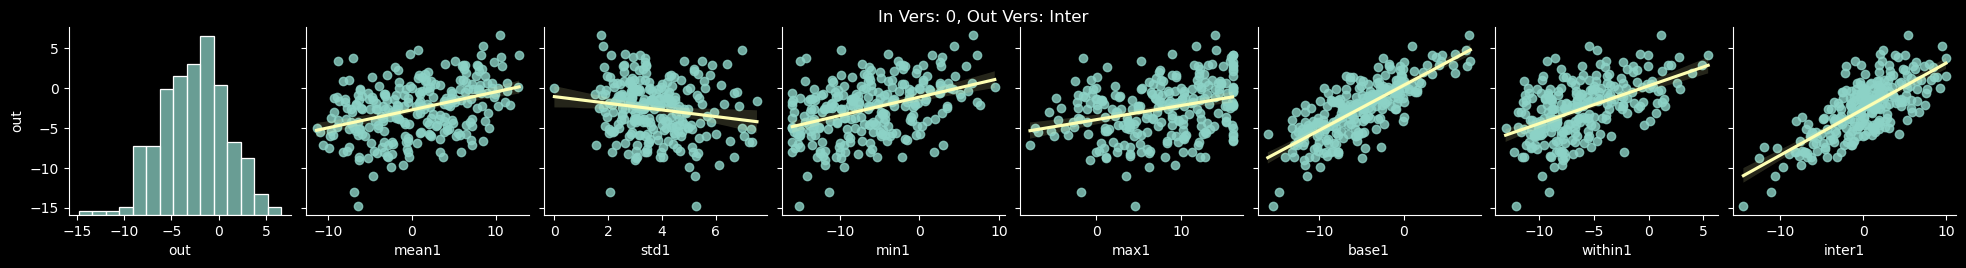

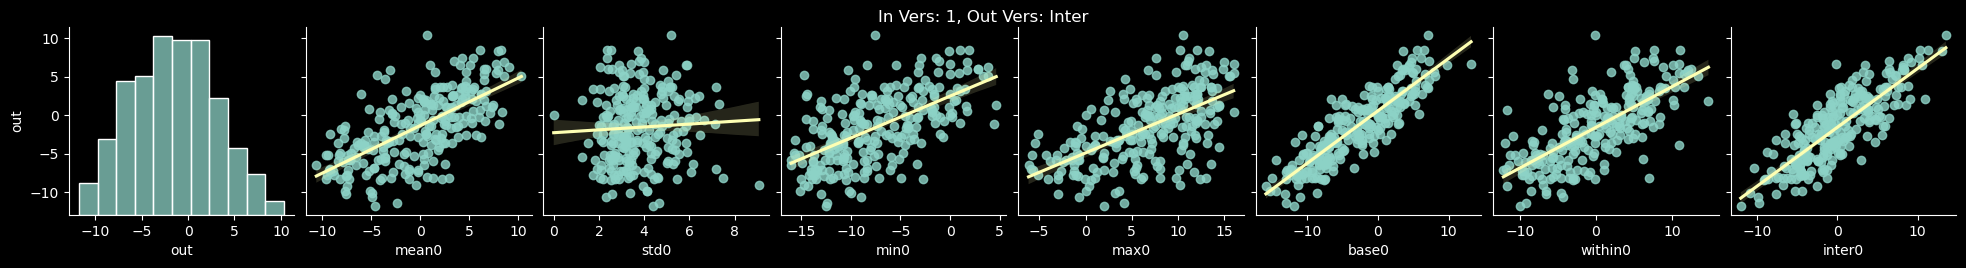

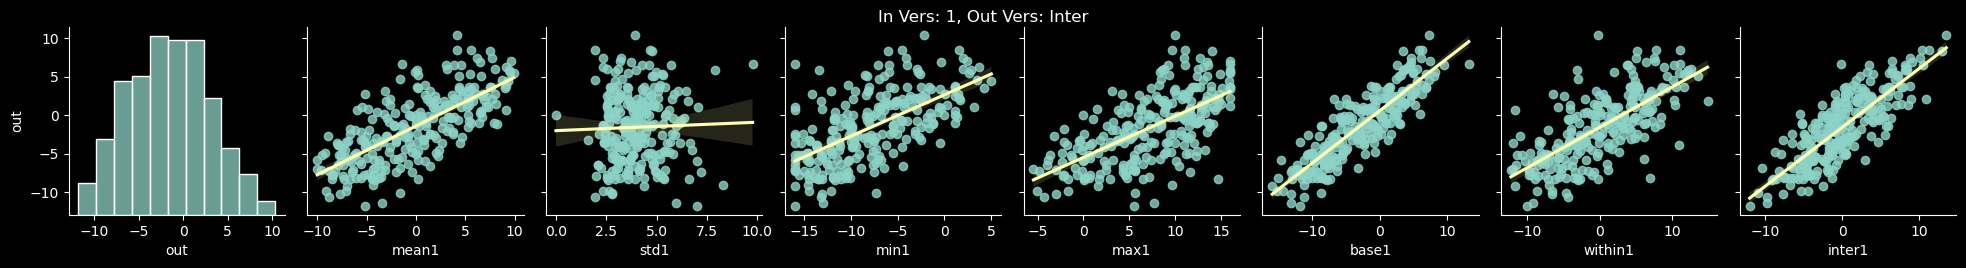

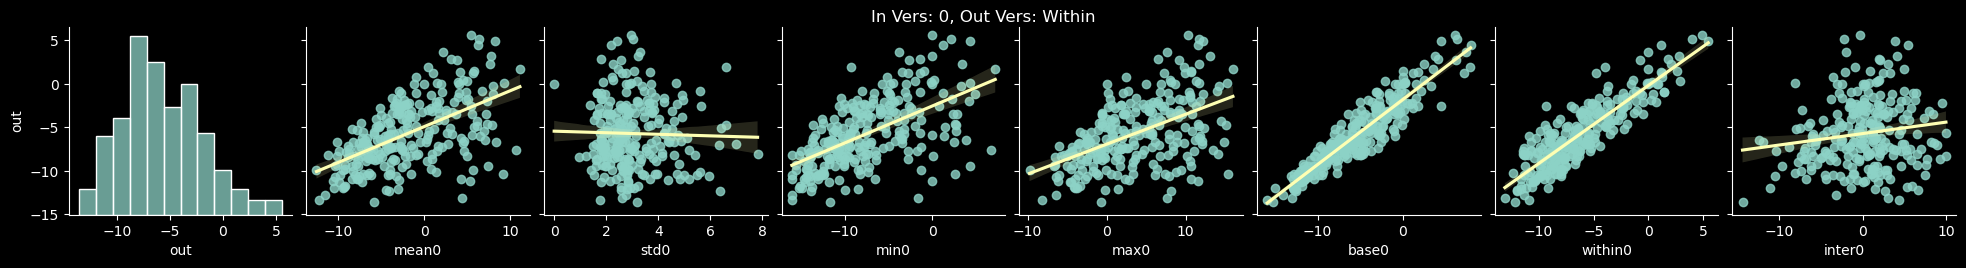

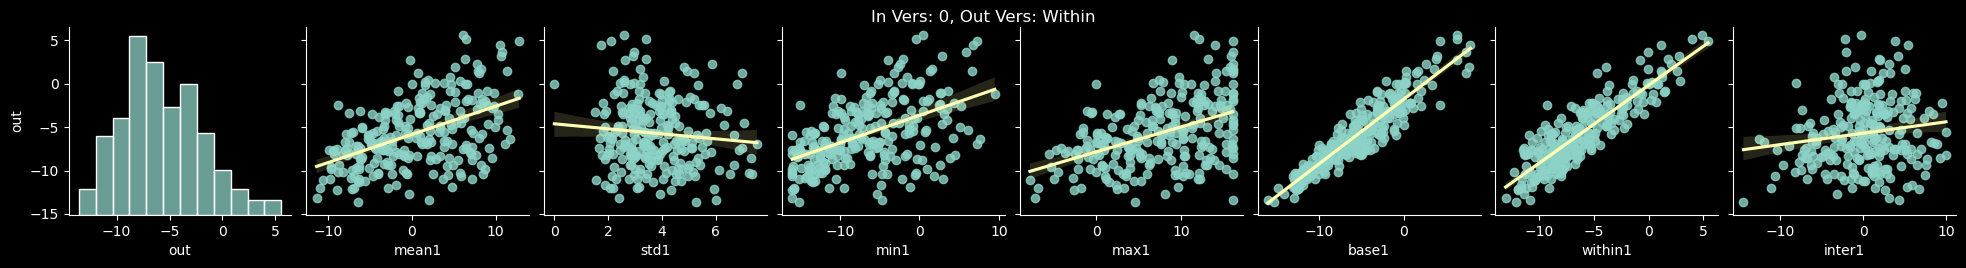

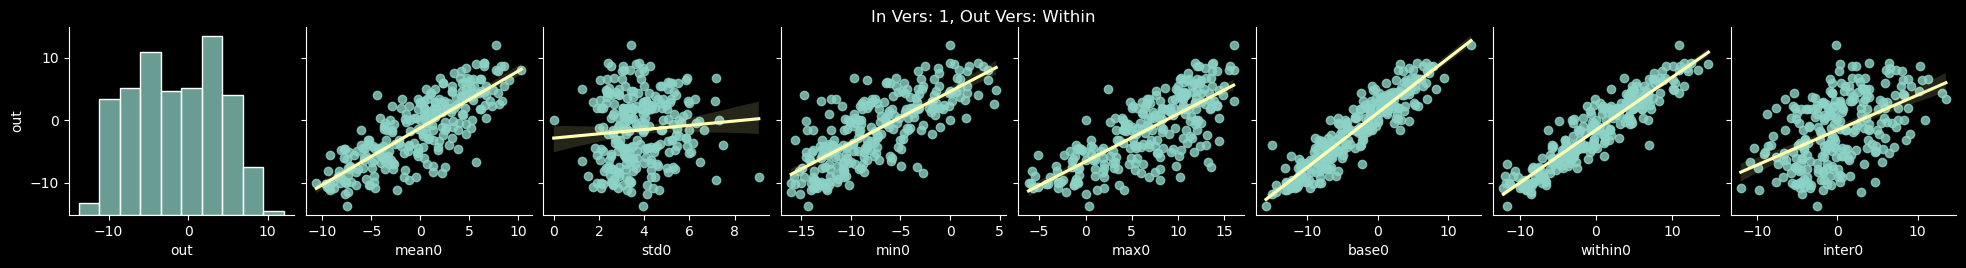

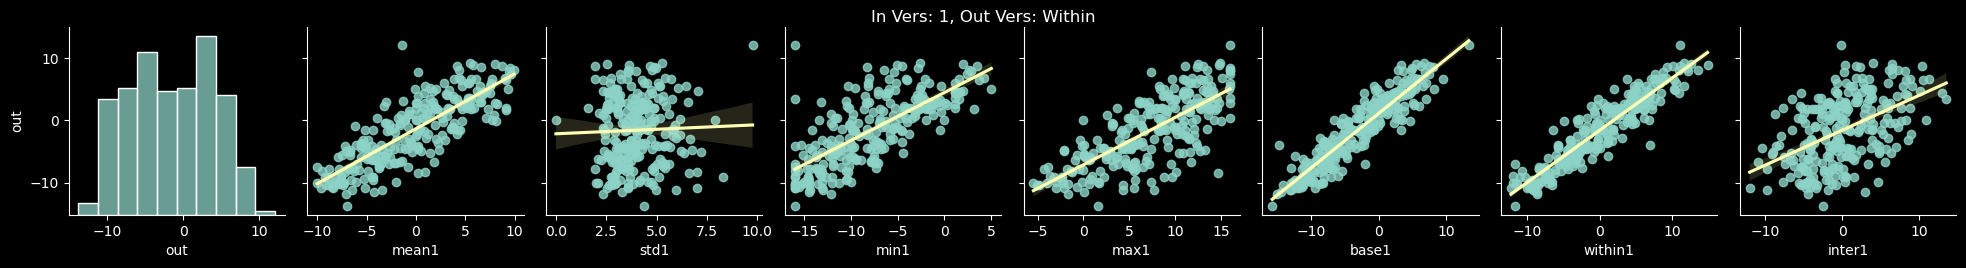

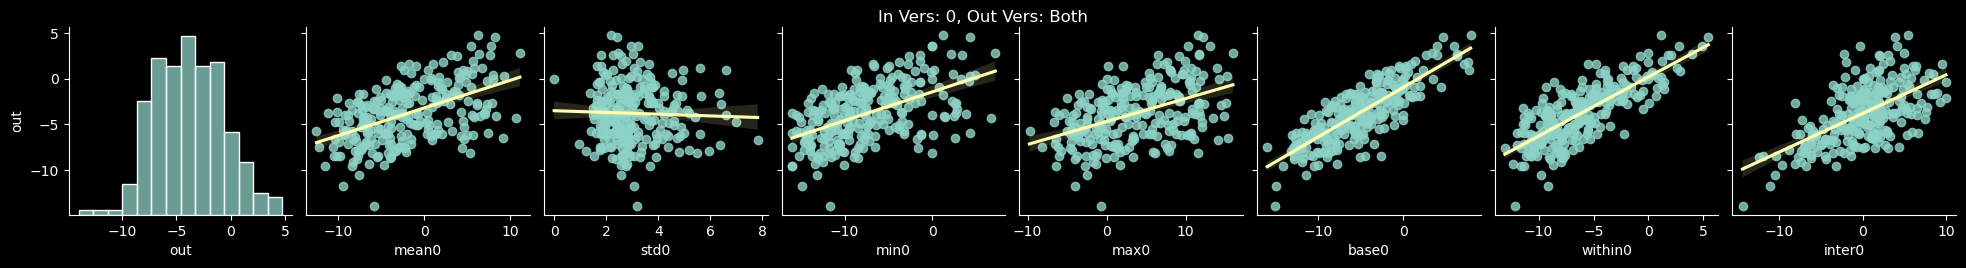

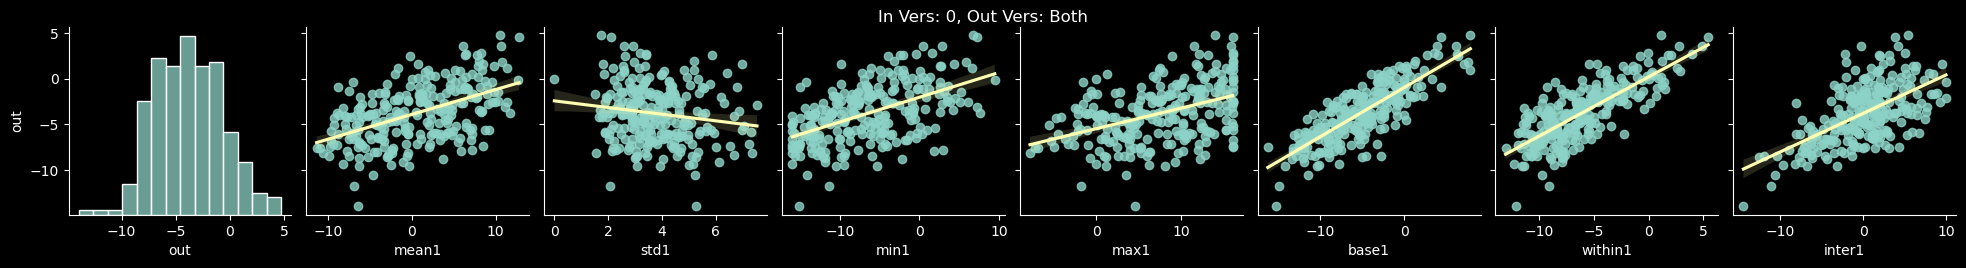

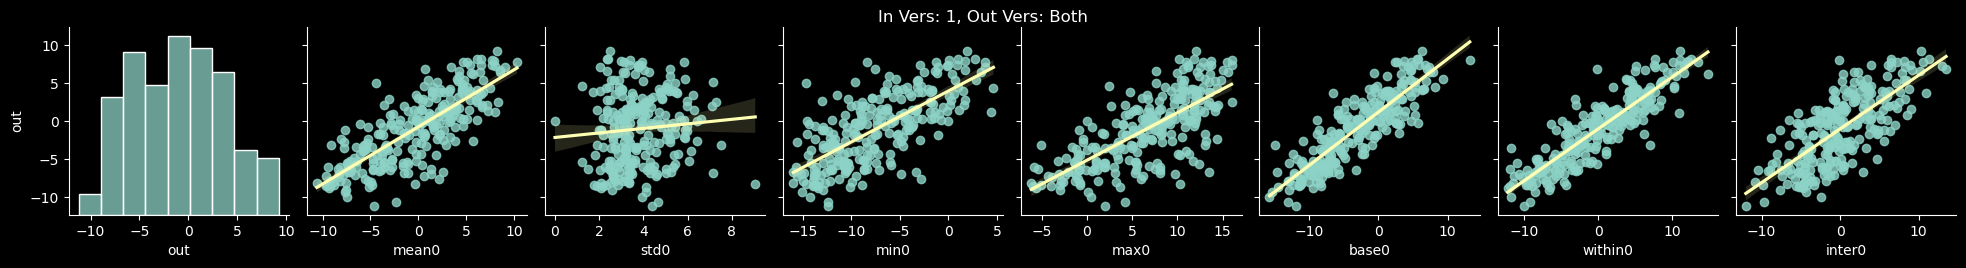

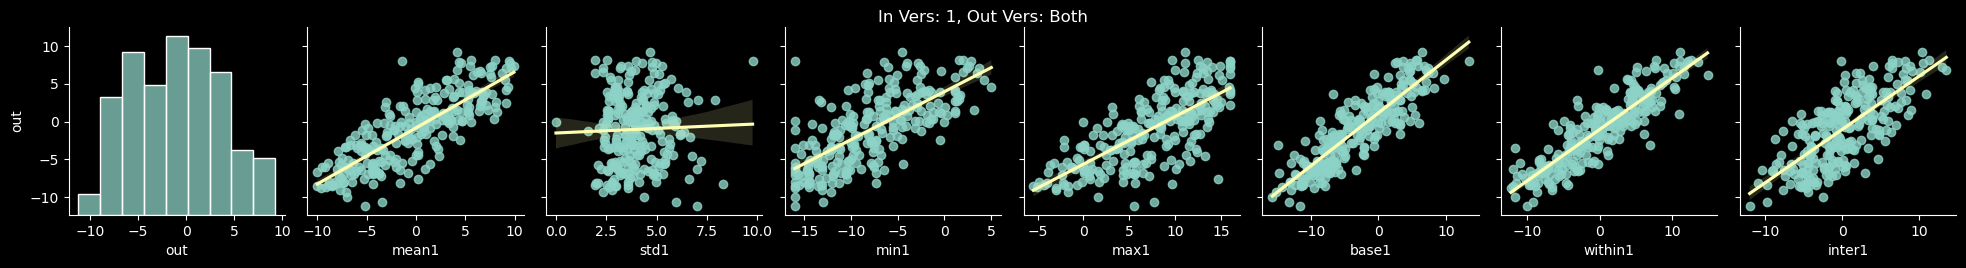

In [10]:
for within in range(2):
    for inter in range(2):
        for vers in range(2):
            for sens in range(In_Dims.numOfSens):
                plt.style.use('dark_background')
                temp = sns.pairplot(stats[within][inter][vers], \
                    x_vars=['out'] + col_names[sens * len(modes):(sens + 1) * len(modes)], y_vars='out', \
                    kind='reg', plot_kws={'line_kws':{'color': plt.rcParams['axes.prop_cycle'].by_key()['color'][1]}})
                
                temp.fig.suptitle(f'In Vers: {vers}, Out Vers: {relation_str(within, inter)}', y=1.03)
                fig_name = stats_path / f'in{vers}_{relation_str(within, inter)}_{sens}.pdf'
                if fig_name.is_file(): fig_name.unlink()
                plt.savefig(fig_name, bbox_inches='tight')
                if sens < 2: plt.show()
                plt.close()

In [11]:
input_name = dataset_path / 'input.npy'
output_name = dataset_path / 'output.npy'
if input_name.is_file(): input_name.unlink()
if output_name.is_file(): output_name.unlink()
np.save(input_name, input)
np.save(output_name, output)

Previous example: [/examples/check_py_env.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/check_py_env.ipynb)  
Next example: [/examples/time_series/cases/1.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/time_series/cases/1.ipynb)